In [2]:
import numpy as np
import pandas as pd

from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [58]:
df = pd.read_csv('../data/weights_heights.csv', sep=',')
df.head()

,Index,Height,Weight
0,1,65.78331,112.9925
1,2,71.51521,136.4873
2,3,69.39874,153.0269
3,4,68.21660,142.3354
4,5,67.78781,144.2971


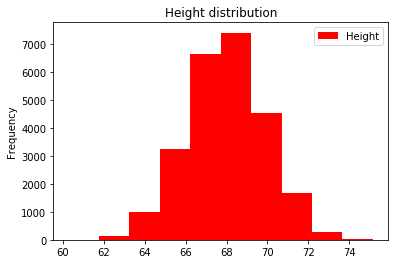

In [18]:
df.plot(y = 'Height', kind = 'hist', color = 'red', title = 'Height distribution')

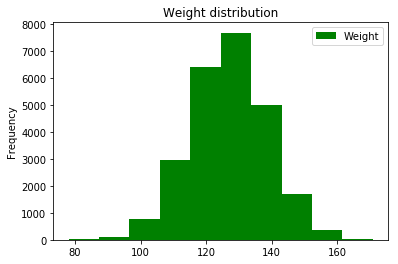

In [19]:
df.plot(y = 'Weight', kind = 'hist', color = 'green', title = 'Weight distribution')

In [21]:
def make_bmi(height, weight):
    METER_TO_INCH, KILO_TO_POUND = 39.37, 2.20462
    return (weight / KILO_TO_POUND) / (height / METER_TO_INCH) ** 2

In [22]:
df['BMI'] = df.apply(lambda row: make_bmi(row['Height'], row['Weight']), axis = 1)

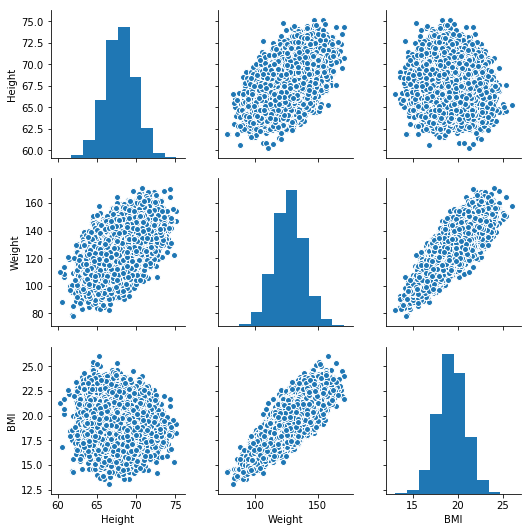

In [23]:
sns.pairplot(df)

In [77]:
def weight_category(weight):
    if weight < 120:
        return 1
    elif weight >= 150:
        return 3
    else:
        return 2

In [25]:
df['weight_category'] = df.apply(lambda row: weight_category(row['Weight']), axis = 1)

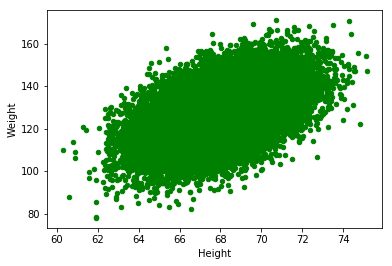

In [27]:
df.plot(x = 'Height', y = 'Weight', kind = 'scatter', color = 'green')

In [39]:
import numpy as np
from scipy.optimize import minimize

class MyRegression():
    def __init__(self, betas=None):
        self.betas = betas

    def MSE(self, betas, X, Y):
        '''Функция вычисляющая среднеквадратическую ошибку прогноза для минимизации'''
        Y_ = np.ndarray.flatten(Y)
        X_transform = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        prediction = X_transform.dot(betas)
        return np.sum((prediction - Y_) ** 2)


    def fit(self, X, Y):
        x_init = np.array([0, 0]) # Начальная точка
        self.betas = x_init
        self.betas = minimize(self.MSE, args=(X,Y), x0=x_init, method='L-BFGS-B')
        
        return self.betas


In [40]:
X = df[['Height']].to_numpy()
Y = df[['Weight']].to_numpy()


model = MyRegression()
model.fit(X, Y)
print(model.betas)

      fun: 2539713.314141401
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -0.51222742, -35.90248525])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 12
   status: 0
  success: True
        x: array([-82.57513772,   3.08346739])


In [42]:
df.head()

,Height,Weight,BMI,weight_category
Index,,,,
1,65.78331,112.9925,18.357573,1
2,71.51521,136.4873,18.762577,1
3,69.39874,153.0269,22.338895,3
4,68.21660,142.3354,21.504526,1
5,67.78781,144.2971,22.077581,1


In [82]:
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn import metrics 

In [78]:
df = pd.read_csv('../data/weights_heights.csv', sep=',')
df.head()

,Index,Height,Weight
0,1,65.78331,112.9925
1,2,71.51521,136.4873
2,3,69.39874,153.0269
3,4,68.21660,142.3354
4,5,67.78781,144.2971


In [79]:
df['weight_category'] = df.apply(lambda row: weight_category(row['Weight']), axis = 1)
df['BMI'] = df.apply(lambda row: make_bmi(row['Height'], row['Weight']), axis = 1)

In [80]:
Y = df[['Height']]
df.drop(['Index', 'Height'], axis=1, inplace=True)
df.head()

,Weight,weight_category,BMI
0,112.9925,1,18.357573
1,136.4873,2,18.762577
2,153.0269,3,22.338895
3,142.3354,2,21.504526
4,144.2971,2,22.077581


In [81]:
X = pd.concat([df,
              pd.get_dummies(df['weight_category'], prefix="weight_category")],axis=1)

X.drop(['weight_category'], axis=1, inplace=True)
    
X.head()

,Weight,BMI,weight_category_1,weight_category_2,weight_category_3
0,112.9925,18.357573,1,0,0
1,136.4873,18.762577,0,1,0
2,153.0269,22.338895,0,0,1
3,142.3354,21.504526,0,1,0
4,144.2971,22.077581,0,1,0


Сравниваем обычную регрессию с регуляризованной (В обучающей выборке есть линейно зависимые строки)

In [84]:
linreg = LinearRegression()
linreg.fit(X, Y)
linreg.coef_

array([[ 0.26493568, -1.74269482,  0.02702325,  0.13447293, -0.16149618]])

In [85]:
Y_pred = linreg.predict(X)
metrics.r2_score(Y_pred, Y)

0.9945399592954041

Lasso-регрессия накладывает ограничения на абсолютные значения весов в модели - как можно видеть, она обнуляет линейно зависимые признаки

In [86]:
lasso = Lasso(alpha=0.1)
lasso.fit(X, Y)
lasso.coef_

array([ 0.25227384, -1.61527478, -0.        ,  0.        , -0.        ])

In [87]:
Y_pred = lasso.predict(X)
metrics.r2_score(Y_pred, Y)

0.9883984450344585

In [90]:
lasso_cv = LassoCV(alphas=np.linspace(0.1, 10, 10), 
                   cv=3, random_state=17)
lasso_cv.fit(X, Y)

/home/makilins/.local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV(alphas=array([ 0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ]),
    copy_X=True, cv=3, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=None, normalize=False, positive=False,
    precompute='auto', random_state=17, selection='cyclic', tol=0.0001,
    verbose=False)

In [91]:
lasso_cv.coef_

array([ 0.25227384, -1.61527478, -0.        ,  0.        , -0.        ])

In [92]:
lasso_cv.alpha_

0.1

Ridge-регрессия - накладывает ограничения на квадраты весов

In [95]:
ridge_alphas = np.logspace(-2, 6, 10)
ridge_alphas

array([1.00000000e-02, 7.74263683e-02, 5.99484250e-01, 4.64158883e+00,
       3.59381366e+01, 2.78255940e+02, 2.15443469e+03, 1.66810054e+04,
       1.29154967e+05, 1.00000000e+06])

In [96]:
ridge_cv = RidgeCV(alphas=ridge_alphas, 
                   scoring='neg_mean_squared_error',
                   cv=3)
ridge_cv.fit(X, Y)

RidgeCV(alphas=array([1.00000e-02, 7.74264e-02, 5.99484e-01, 4.64159e+00, 3.59381e+01,
       2.78256e+02, 2.15443e+03, 1.66810e+04, 1.29155e+05, 1.00000e+06]),
    cv=3, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring='neg_mean_squared_error', store_cv_values=False)

In [97]:
ridge_cv.coef_

array([[ 0.26492839, -1.74264624,  0.02692732,  0.13441278, -0.1613401 ]])

In [98]:
ridge_cv.alpha_

0.5994842503189409

In [99]:
Y_pred = ridge_cv.predict(X)
metrics.r2_score(Y_pred, Y)

0.9945397289907578